**Minimum Distance and Correlation Approaches to Finding Asset Pairs**

In [12]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import yfinance as yf
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [105]:
class min_dist_approach:
    def __init__(self, ticker_x: list):
        """Tickers are passed as lists of strings."""
        self.ticker_x = ticker_x
        
    def get_data(self, ticker, period = "1mo", interval = "1d", actions = False):
        """Takes ticker as required parameter and returns historical price data. Uses parameters from yfinance. 
        Actions = False means that dividends and stock split data is not returned. All columns are adjusted prices. WARNING:
        DOESN'T WORK WITH HOURLY Intervals between cryptos and equities due to equities returning on the half hour"""
        x_tick = yf.Ticker(str(ticker))
        x_hist = x_tick.history(period = period, interval = interval, actions = actions)

        if x_hist.index.tzinfo is not None:
            x_hist.index = pd.to_datetime(x_hist.index).tz_convert("UCT")
            return x_hist
        else:
            return x_hist

    def get_returns(self, x_hist):
        """Takes historical data as required parameter."""
        x_ret = x_hist.pct_change().replace(np.inf, np.nan).dropna()
        return x_ret

    def minmaxnorm(self, x_ret):
        "Normalizes the returns"
        scaler = MinMaxScaler()
        scaler.fit(x_ret.values.reshape(-1,1))
        x_norm = scaler.transform(x_ret.values.reshape(-1,1))
        x_norm_df = pd.DataFrame(x_norm, index=x_ret.index, columns=[x_ret.name])

        return x_norm_df
    
    
    def MDA(self, period = "1mo", interval = "1d", actions = False, OHLC = "Close"):
        norm_ret = {}
        
        #initializes a dataframe with the data of the first ticker
        data_x = self.get_data(str(self.ticker_x[0]), period = period, interval = interval, actions = actions)
        ret_x = self.get_returns(data_x)[OHLC]
        df_norm_ret= self.minmaxnorm(ret_x)
        df_norm_ret.columns = [self.ticker_x[0]+"_"+OHLC]
        
        for ticker in self.ticker_x[1:]:
            data_x = self.get_data(str(ticker), period = period, interval = interval, actions = actions)
            ret_x = self.get_returns(data_x)[OHLC]
            df_norm = self.minmaxnorm(ret_x)
            df_norm.columns = [ticker +"_"+OHLC]
            df_norm_ret = df_norm_ret.merge(df_norm, how="inner", left_index=True, right_index=True)
        
        eucl = {}
        for i,col in enumerate(df_norm_ret.columns):
            columns =set(df_norm_ret.columns) - {col}
            for c in columns:
                eucl[col + " & " + c] = self.euclidian(df_norm_ret[c], df_norm_ret[col])
        eucl_df = pd.DataFrame.from_dict(eucl, orient="index", columns=["Euclidian Distance"]).sort_values(["Euclidian Distance"],ascending=True).drop_duplicates()
        return eucl_df
        
    def euclidian(self,a,b):
        "Takes in pandas series (columns of a pandas DF) and returns a pandas series"
        euclidian_series = np.sqrt((a - b)**2)
        return sum(euclidian_series)



Below, we will search for pairs among BTC-USD and BTC ETFs.

In [122]:
#bitcoin etfs: https://www.forbes.com/advisor/investing/cryptocurrency/best-bitcoin-etfs/
btc = ["BTC-USD", "BITO", "BTF","XBTF","CRYP","BITS","BITI"]

crypto = ["ETH-USD", "SPLG", "BTC-USD", "NEAR-USD","SOL-USD","AVAX-USD","ADA-USD", "ATOM-USD"]
m = min_dist_approach(btc)

exp = m.MDA(period = "6mo")
print(exp.head(10))


                         Euclidian Distance
BITO_Close & BTF_Close             0.358261
BTF_Close & XBTF_Close             0.733410
BITO_Close & XBTF_Close            0.948510
CRYP_Close & XBTF_Close            2.030654
BTF_Close & CRYP_Close             2.080307
BITO_Close & CRYP_Close            2.142751
BTF_Close & BITS_Close             3.851632
XBTF_Close & BITS_Close            3.892443
BITS_Close & BITO_Close            3.936964
BITS_Close & CRYP_Close            4.215389


Above, it can be seen that some possible pairs are:
    1. BITO & BTF
    2. BTF & XBTF
    3. BITO & XBTF
    
In future work, these pairs will be tested in a trading strategy.

**Correlation Approach**

The Correlation Approach class does the following:
    1. Finds returns and builds a correlation matrix.
    2. Calculates a matrix of spread variances from correlation matrix.

In [61]:
class correlation_approach:
    def __init__(self, ticker_x: list):
        """Tickers are passed as lists of strings."""
        self.ticker_x = ticker_x
        
        
    def get_data(self, ticker, period = "1mo", interval = "1d", actions = False):
        """Takes ticker as required parameter and returns historical price data. Uses parameters from yfinance. 
        Actions = False means that dividends and stock split data is not returned. All columns are adjusted prices. WARNING:
        DOESN'T WORK WITH HOURLY Intervals between cryptos and equities due to equities returning on the half hour"""
        x_tick = yf.Ticker(str(ticker))
        x_hist = x_tick.history(period = period, interval = interval, actions = actions)

        if x_hist.index.tzinfo is not None:
            x_hist.index = pd.to_datetime(x_hist.index).tz_convert("UCT")
            return x_hist
        else:
            return x_hist
        

    def get_returns(self, x_hist):
        """Takes historical data as required parameter."""
        x_ret = x_hist.pct_change().replace(np.inf, np.nan).dropna()
        return x_ret
        
        
    def data_df(self, period = "1mo", interval = "1d", actions = False, OHLC = "Close"):
        """Returns dataframe of returns"""
        
        indicator = None
        
        for ticker in self.ticker_x:
            x_hist = self.get_data(ticker, period = period, interval = interval, actions = actions)
            x_ret = pd.DataFrame(self.get_returns(x_hist)[OHLC])
            x_ret.columns = [ticker + "_" + OHLC]
            
            if indicator == None:
                ret_df = pd.DataFrame(x_ret)
                indicator = 1
            else:
                ret_df = ret_df.merge(x_ret, how="inner", left_index=True, right_index=True)
                
        return ret_df
        
    def correlation(self, period = "1mo", interval = "1d", actions = False, OHLC = "Close"):
        """Takes two tickers and returns adjusted"""
        
        dm = self.data_df(period = period, interval = interval, actions = actions, OHLC = OHLC)
        cm = dm.corr()
        return cm
    
    def spread_var(self, period = "1mo", interval = "1d", actions = False, OHLC = "Close"):
        variances = self.data_df().var()
        cm = self.correlation(period = period, interval = interval, actions = actions, OHLC = OHLC)
        
        spreadvar = cm #initializes the spreadvar df
        
        for index in range(len(cm)):
            for col in range(len(cm.columns)):
                spreadvar.iloc[index,col] = variances[index] + variances[col] - 2*cm.iloc[index,col]*np.sqrt(variances[index])*np.sqrt(variances[col])
        
        return spreadvar
        

In [119]:
#Referenced from: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def heat_it_up(df, axis_labels, cbarlabel, figsize=(9,9), decimal_places = 2, notation_type = "e"):
    """Creates the heatmap"""

    fig, ax = plt.subplots(figsize=figsize)

    im, cbar = heatmap(df, row_labels=axis_labels, col_labels=axis_labels, ax=ax,
                      cmap="YlGn", cbarlabel=cbarlabel)
    texts = annotate_heatmap(im, valfmt="{x:."+ str(decimal_places)+ notation_type+"}")

    fig.tight_layout()
    plt.show()

In [108]:
btc = ["BTC-USD", "BITO", "BTF","XBTF","CRYP","BITS","BITI"]
crypto = ["ETH-USD", "SPLG", "BTC-USD", "NEAR-USD","SOL-USD","AVAX-USD","ADA-USD", "ATOM-USD"]

ca = correlation_approach(btc)
cr =  ca.correlation()
sv = ca.spread_var()

Here are the correlations of the assets:

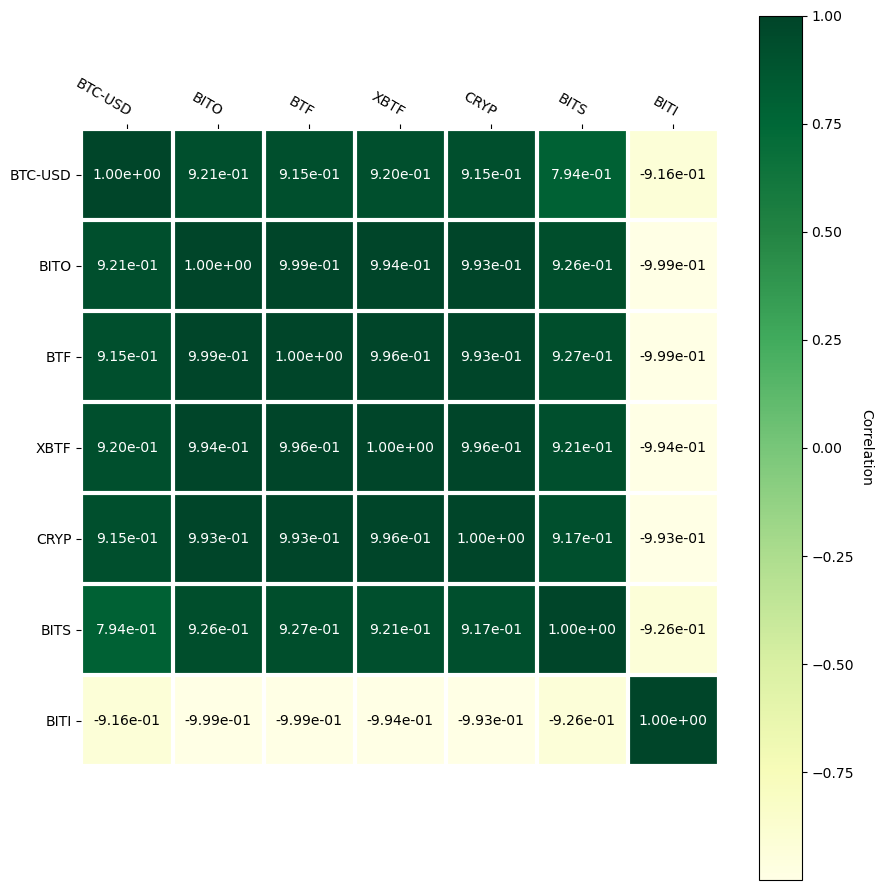

In [120]:
heat_it_up(cr, btc, cbarlabel="Correlation")

Here is a heat map of the spread variance matrix.

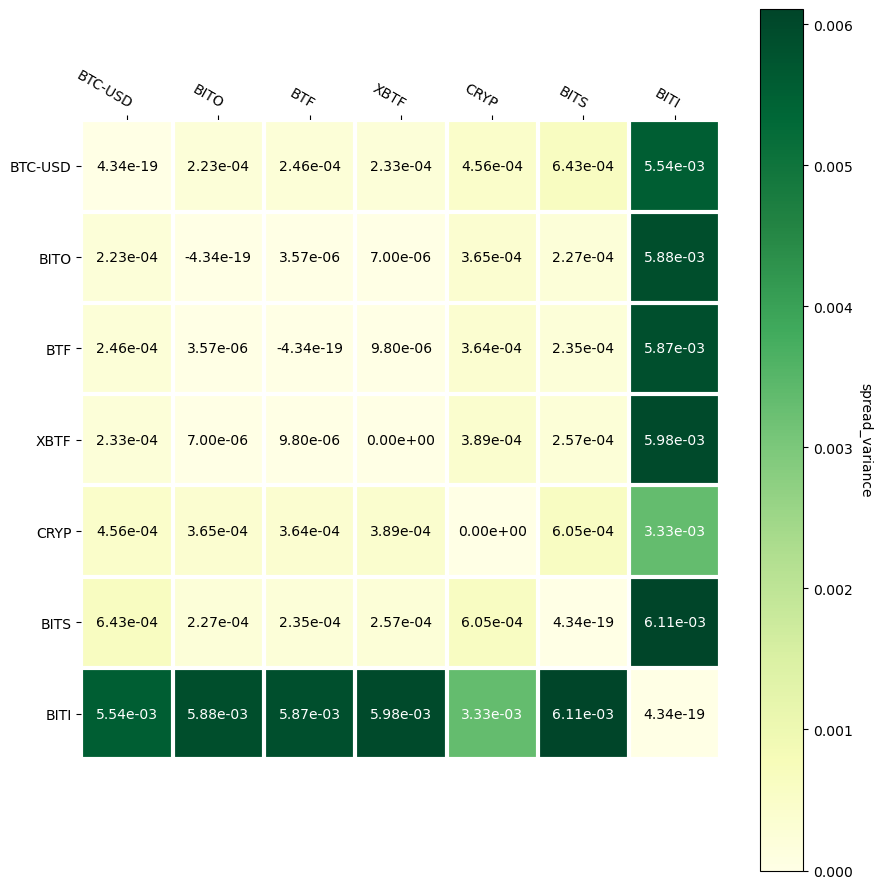

In [100]:
heat_it_up(sv, btc, "spread_variance")

The lowest spread variance pairs from above are the following.
    1. BTF & BITO
    2. XBTF & BITO
    3. XBTF & BTF
    
It happens to be the case that these same three pairs were the results of the Minimum Distance approach as well.

In future work, these pairs will be tested in a trading strategy.